In [1]:
import numpy as np
import keras
from keras.applications.mobilenetv2 import (MobileNetV2, preprocess_input, decode_predictions)
from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.layers.core import Lambda
import keras.backend as K
import tensorflow as tf

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/jinsakuma/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jinsakuma/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jinsakuma/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jinsakuma/anaconda3/lib/python3.6/sit

In [2]:
model = MobileNetV2(weights = "imagenet")

In [3]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def grad_cam(input_model, image, nb_classes, category_index, layer_name):
    
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    loss = K.sum(model.layers[-1].output)
    conv_output =  [l for l in model.layers if l.name == layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.zeros(output.shape[0 : 2], dtype = np.float32) 

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - np.min(cam))/(np.max(cam) - np.min(cam))

    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    if max(image.reshape(-1)) < 255.0:
        cam = np.float32(cam) + np.float32(image*255.0)
    else:
        cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

tabby: 49.93%
tiger_cat: 32.48%
Egyptian_cat: 5.65%


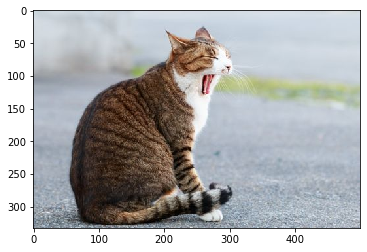

In [4]:
path = "./images/cat.jpg"
img = cv2.imread(path)
plt.imshow(img[:,:,::-1])
X = load_image(path)
preds = model.predict(X)
classes_num = preds.shape[1]
pred_classes = np.argmax(preds)
result = decode_predictions(preds, top=3)[0]
for _, name, score in result:
    print('{}: {:.2%}'.format(name, score))

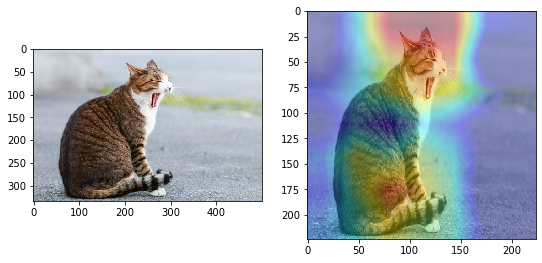

In [5]:
cam, heatmap = grad_cam(model, X, classes_num, pred_classes, "Conv_1")
plt.figure(figsize = (9,6))
plt.subplot(1, 2, 1)
plt.imshow(img[:,:,::-1])
plt.subplot(1, 2, 2)
plt.imshow(cam/255)

Labrador_retriever: 35.72%
beagle: 12.63%
dalmatian: 5.60%


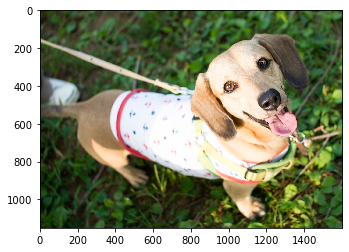

In [6]:
path2 = "./images/dog.jpg"
img2 = cv2.imread(path2)
plt.imshow(img2[:,:,::-1])
X2 = load_image(path2)
preds2 = model.predict(X2)
classes_num = preds.shape[1]
pred_classes2 = np.argmax(preds2)
result2 = decode_predictions(preds2, top=3)[0]
for _, name, score in result2:
    print('{}: {:.2%}'.format(name, score))

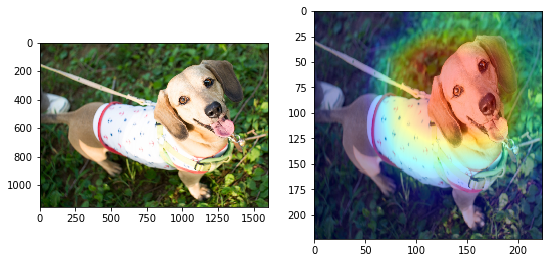

In [7]:
cam2, heatmap2 = grad_cam(model, X2, classes_num, pred_classes2, "Conv_1")
plt.figure(figsize = (9,6))
plt.subplot(1, 2, 1)
plt.imshow(img2[:,:,::-1])
plt.subplot(1, 2, 2)
plt.imshow(cam2/255)

In [8]:
save_img("./result/cat_result.jpg", cam)
save_img("./result/dog_result.jpg", cam2)